In [1]:
# import dependencies
import pandas as pd
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

import datetime
import matplotlib.pyplot as plt

In [2]:
# reflect database tables (Measurment & Station) into classes
engine = create_engine("sqlite:///hawaii.sqlite", echo=False)

Base = automap_base()
Base.prepare(engine, reflect=True)
Measurement = Base.classes.measurement
Station = Base.classes.station

session = Session(engine)

In [3]:
# plot last year's worth of precipitation

current_datetime = datetime.datetime.now()
year = datetime.timedelta(days=365)
year_ago = current_datetime - year

recent_prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > year_ago).all()

prcp_df = pd.DataFrame.from_records(recent_prcp, columns=['Date','Precipitation'])

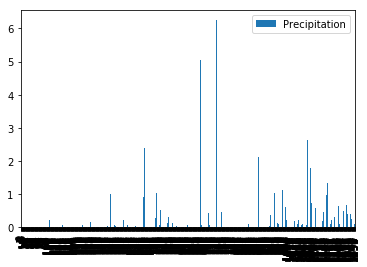

In [4]:
prcp_df.plot(kind='bar')
plt.show()

In [5]:
# summary statistics for precipitation
prcp_df.describe()

,Precipitation
count,1257.000000
mean,0.166953
std,0.455506
min,0.000000
25%,0.000000
50%,0.000000
75%,0.110000
max,6.250000


In [6]:
# query for the total number of stations
station_count = session.query(Station.station).count()
station_count

# query for most active stations
stations_by_activity = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

stations_df = pd.DataFrame.from_records(stations_by_activity, columns=['Station','Observations'])
most_obs = stations_df["Station"][stations_df["Observations"].idxmax()]
most_obs

'USC00519281'

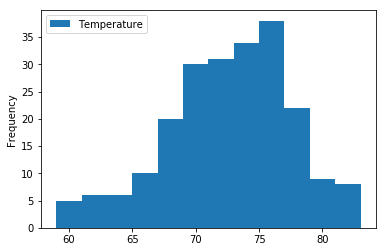

In [7]:
# plot the last 12 months of temperature data from the most active station

recent_temps = session.query(Measurement.station, Measurement.date, Measurement.tobs)\
    .filter(Measurement.date > year_ago).filter(Measurement.station == most_obs).all()
recent_temps_df = pd.DataFrame.from_records(recent_temps, columns=['Station','Date','Temperature'])

recent_temps_df.plot(kind='hist', bins=12)
plt.show()

In [8]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

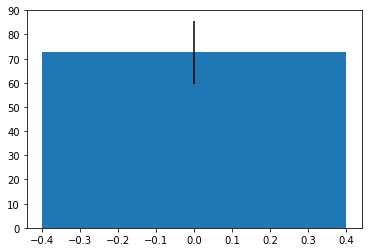

In [9]:
# Use the calc_temps function to calculate the min, avg, and max temperatures for your trip using the matching dates 
# from the previous year (i.e. use "2017-01-01" if your trip start date was "2018-01-01")

trip_start = '2018-03-17'
trip_end = '2018-03-24'

last_year_start = datetime.datetime.strptime(trip_start, '%Y-%m-%d') - year
start_date = last_year_start.strftime('%Y-%m-%d')
last_year_end = datetime.datetime.strptime(trip_end, '%Y-%m-%d') - year
end_date = last_year_end.strftime('%Y-%m-%d')

trip_temps = calc_temps(start_date, end_date)
min_temp, avg_temp, max_temp = trip_temps[0]

plt.bar(0, avg_temp, yerr=max_temp-min_temp)
plt.show()

In [16]:
# calculate the rainfall per weather station using the previous year's matching dates.
trip_rain = session.query(Measurement.station, func.sum(Measurement.prcp))\
    .filter(Measurement.date >= last_year_start).filter(Measurement.date <= last_year_end).group_by(Measurement.station).all()
trip_rain

[('USC00513117', 0.6),
 ('USC00514830', 0.15),
 ('USC00516128', 0.2),
 ('USC00519281', 0.22999999999999998),
 ('USC00519397', 0.02),
 ('USC00519523', 0.09000000000000001)]

In [51]:
def daily_normals(date):
    """Calculates daily normals (average min, max, and average temp) for a provided date.
    
    Args:
        date (string): A date string in the format %m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    historic_norms = session.query(Measurement.date, func.min(Measurement.tobs), func.avg(Measurement.tobs),\
        func.max(Measurement.tobs)).filter(func.strftime('%m-%d', Measurement.date) == date).group_by(Measurement.date).all()
    
    
    historic_norms_df = pd.DataFrame.from_records(historic_norms, columns=['Date','Min','Avg','Max'])
    TMIN = historic_norms_df['Min'].mean()
    TAVE = historic_norms_df['Avg'].mean()
    TMAX = historic_norms_df['Max'].mean()
    
    
    return (TMIN, TAVE, TMAX)

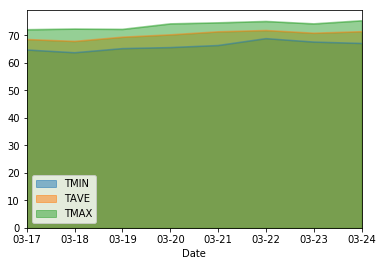

In [57]:
# trip_start = '2018-03-17'
# trip_end = '2018-03-24'

start_datetime = datetime.datetime.strptime(trip_start, '%Y-%m-%d')
end_datetime = datetime.datetime.strptime(trip_end, '%Y-%m-%d')
trip_length = (end_datetime - start_datetime).days

trip_range = []

for day in range(trip_length + 1):
    trip_date = start_datetime + datetime.timedelta(days=day)
    formatted_date = trip_date.strftime('%m-%d')
    trip_range.append(formatted_date)

daily_normals_list = []

for date in trip_range:
    normals = daily_normals(date)
    daily_normals_list.append(normals)

daily_normals_df = pd.DataFrame.from_records(daily_normals_list, columns=['TMIN','TAVE', 'TMAX'])
daily_normals_df["Date"] = trip_range
daily_normals_df = daily_normals_df.set_index("Date")
daily_normals_df.plot(kind='area', stacked=False)
plt.show()
    